<a href="https://colab.research.google.com/github/hondore16/PIONS/blob/main/%D0%9A%D0%A3%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8FGNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Starting GNN NAS with evolutionary strategy...

Iteration 1/20
Generated architecture: {'layer_type': 'GraphSAGE', 'num_layers': 3, 'hidden_dim': 256, 'heads': 2, 'dropout_rate': 0.07, 'use_batchnorm': True}
Epoch 1/10: Loss = 1.4084, Val Acc = 0.2733
Epoch 2/10: Loss = 1.3574, Val Acc = 0.2400
Epoch 3/10: Loss = 1.3081, Val Acc = 0.2667
Epoch 4/10: Loss = 1.2614, Val Acc = 0.2333
Epoch 5/10: Loss = 1.2179, Val Acc = 0.2600
Epoch 6/10: Loss = 1.0895, Val Acc = 0.2267
Epoch 7/10: Loss = 0.9853, Val Acc = 0.2533
Epoch 8/10: Loss = 0.9507, Val Acc = 0.2933
Epoch 9/10: Loss = 0.8037, Val Acc = 0.2667
Epoch 10/10: Loss = 0.7139, Val Acc = 0.2667
Architecture accuracy: 0.2933

Iteration 2/20
Generated architecture: {'layer_type': 'GraphSAGE', 'num_layers': 4, 'hidden_dim': 256, 'heads': 2, 'dropout_rate': 0.146, 'use_batchnorm': True}
Epoch 1/10: Loss = 1.4001, Val Acc = 0.2467
Epoch 2/10: Loss = 1.3761, Val Acc = 0.2533
Epoch 3/10: Loss = 1.3361, Val Acc = 0.2467
Epoch 4/

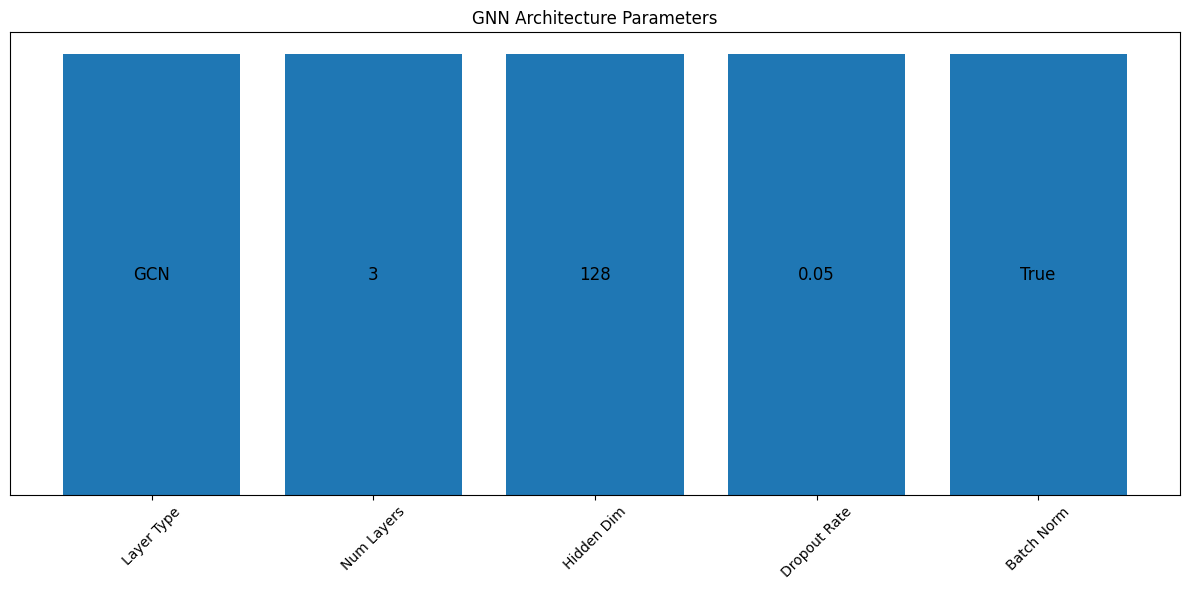

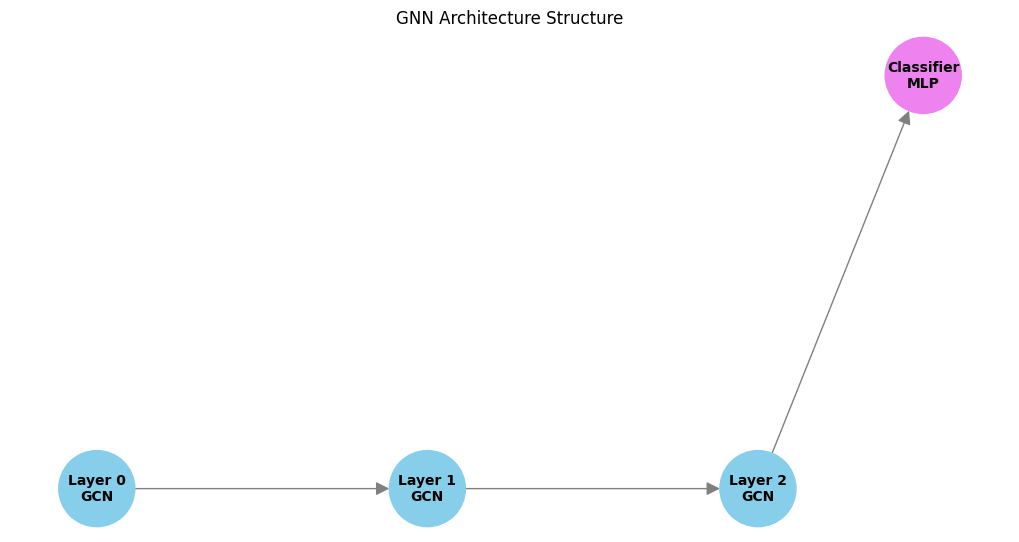


Search progress analysis:


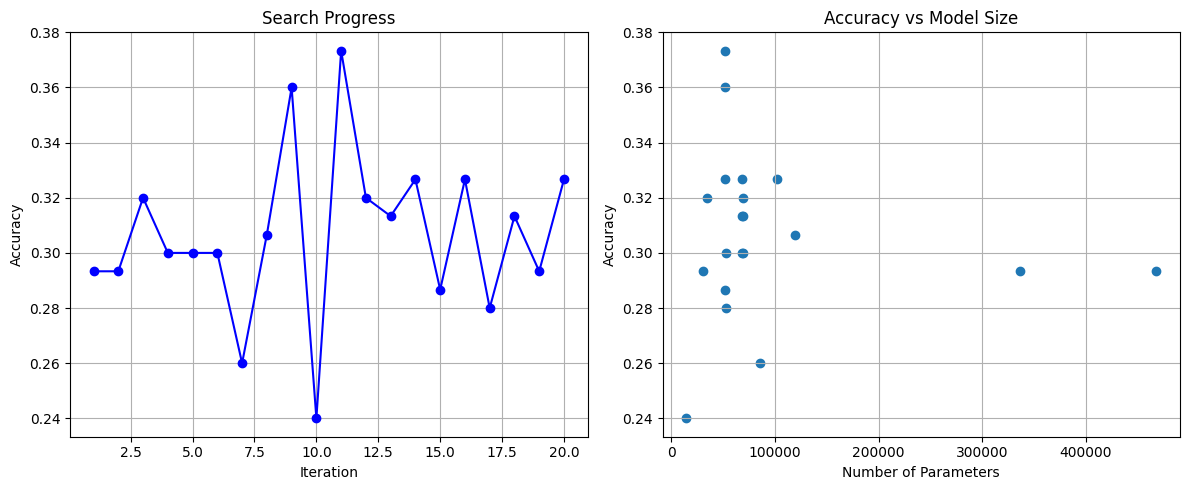


Test Accuracy: 0.2000

=== Key Recommendations for GNNs ===
1. Best layer type: GCN
2. Optimal layers: 3
3. Hidden dim size: 128
4. Dropout rate: 0.05
5. Use batch norm: True

Best Architecture: {'layer_type': 'GCN', 'num_layers': 3, 'hidden_dim': 128, 'heads': 2, 'dropout_rate': 0.053, 'use_batchnorm': True}


In [12]:
# Установка зависимостей
!pip install torch torchvision torch-geometric matplotlib networkx pandas
!pip install torchsummary

# Импорт библиотек
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from typing import Dict, Any, List, Tuple
import math
import time
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool
from torchsummary import summary

# Настройка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Функция для объединения графов в батчи
def collate_fn(batch):
    return Batch.from_data_list(batch)

# Класс для генерации синтетических графов
class SyntheticGraphDataset(Dataset):
    def __init__(self, num_samples=1000, num_classes=4, max_nodes=50):
        self.num_samples = num_samples
        self.num_classes = num_classes
        self.max_nodes = max_nodes
        self.data = self._generate_data()

    def _generate_graph(self) -> Tuple[nx.Graph, int]:
        num_nodes = random.randint(10, self.max_nodes)
        G = nx.erdos_renyi_graph(num_nodes, p=0.15)
        label = random.randint(0, self.num_classes-1)
        return G, label

    def _graph_to_data(self, G: nx.Graph, label: int) -> Data:
        x = torch.randn((len(G.nodes()), 10))
        edge_index = torch.tensor(list(G.edges())).t().contiguous()
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
        return Data(x=x, edge_index=edge_index, y=torch.tensor([label]))

    def _generate_data(self) -> List[Data]:
        data_list = []
        for _ in range(self.num_samples):
            G, label = self._generate_graph()
            data = self._graph_to_data(G, label)
            data_list.append(data)
        return data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Класс NAS Framework для GNN
class GNNSearchSpace:
    def __init__(self, search_space: Dict[str, Any], search_strategy: str = 'evolutionary'):
        self.search_space = search_space
        self.search_strategy = search_strategy
        self.history = []
        self.best_accuracy = 0
        self.best_architecture = None

    def generate_architecture(self) -> Dict[str, Any]:
        if self.search_strategy == 'random':
            return self._generate_random_architecture()
        elif self.search_strategy == 'evolutionary':
            return self._generate_evolutionary_architecture()
        else:
            raise ValueError(f"Unknown search strategy: {self.search_strategy}")

    def _generate_random_architecture(self) -> Dict[str, Any]:
        arch = {}
        for key, options in self.search_space.items():
            if key == 'num_classes':
                continue
            if isinstance(options, list):
                arch[key] = random.choice(options)
            elif isinstance(options, dict) and 'range' in options:
                if options['type'] == 'int':
                    arch[key] = random.randint(*options['range'])
                elif options['type'] == 'float':
                    arch[key] = round(random.uniform(*options['range']), 3)

        # Ensure hidden_dim is divisible by heads for GAT
        if arch.get('layer_type') == 'GAT' and 'hidden_dim' in arch and 'heads' in arch:
            arch['hidden_dim'] = (arch['hidden_dim'] // arch['heads']) * arch['heads']

        return arch

    def _generate_evolutionary_architecture(self) -> Dict[str, Any]:
        if not self.history or random.random() < 0.2:
            return self._generate_random_architecture()

        tournament_size = min(5, len(self.history))
        candidates = random.sample(self.history, tournament_size)
        parent = max(candidates, key=lambda x: x['accuracy'])['architecture']

        child = parent.copy()
        for key in child.keys():
            if random.random() < 0.4:
                if isinstance(self.search_space[key], list):
                    child[key] = random.choice(self.search_space[key])
                elif isinstance(self.search_space[key], dict):
                    if self.search_space[key]['type'] == 'int':
                        new_val = child[key] + random.randint(-1, 1)
                        child[key] = max(min(new_val, self.search_space[key]['range'][1]),
                                      self.search_space[key]['range'][0])
                    elif self.search_space[key]['type'] == 'float':
                        new_val = child[key] + random.uniform(-0.1, 0.1)
                        child[key] = round(max(min(new_val, self.search_space[key]['range'][1]),
                                         self.search_space[key]['range'][0]), 3)

        # Ensure hidden_dim is divisible by heads for GAT
        if child.get('layer_type') == 'GAT' and 'hidden_dim' in child and 'heads' in child:
            child['hidden_dim'] = (child['hidden_dim'] // child['heads']) * child['heads']

        return child

    def evaluate_architecture(self, architecture: Dict[str, Any],
                            train_loader: DataLoader,
                            val_loader: DataLoader,
                            epochs: int = 10) -> float:
        model = self.create_model(architecture).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        best_val_accuracy = 0

        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()
                out = model(batch)
                loss = criterion(out, batch.y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for batch in val_loader:
                    batch = batch.to(device)
                    out = model(batch)
                    pred = out.argmax(dim=1)
                    correct += (pred == batch.y).sum().item()
                    total += batch.y.size(0)

            val_accuracy = correct / total
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy

            print(f"Epoch {epoch+1}/{epochs}: Loss = {train_loss/len(train_loader):.4f}, Val Acc = {val_accuracy:.4f}")

        self.history.append({
            'architecture': architecture,
            'accuracy': best_val_accuracy
        })

        if best_val_accuracy > self.best_accuracy:
            self.best_accuracy = best_val_accuracy
            self.best_architecture = architecture.copy()

        return best_val_accuracy

    def create_model(self, architecture: Dict[str, Any]) -> nn.Module:
        class GNNModel(nn.Module):
            def __init__(self, architecture, num_classes=4):
                super().__init__()
                self.layers = nn.ModuleList()
                in_channels = 10

                for i in range(architecture['num_layers']):
                    gnn_layer = self._create_gnn_layer(
                        layer_type=architecture['layer_type'],
                        in_channels=in_channels,
                        out_channels=architecture['hidden_dim'],
                        heads=architecture.get('heads', 1)
                    )
                    self.layers.append(gnn_layer)

                    # Calculate output dimension considering heads for GAT
                    out_dim = architecture['hidden_dim']
                    if architecture['layer_type'] == 'GAT':
                        out_dim *= architecture.get('heads', 1)
                    if architecture['layer_type'] == 'GAT':
                          out_dim = architecture['hidden_dim']
                    else:
                          out_dim = architecture['hidden_dim']
                    if architecture['use_batchnorm']:
                        self.layers.append(nn.BatchNorm1d(out_dim))

                    # Add activation function
                    self.layers.append(nn.ReLU())

                    # Add dropout
                    self.layers.append(nn.Dropout(architecture['dropout_rate']))

                    in_channels = out_dim

                # Final classifier
                self.classifier = nn.Sequential(
                    nn.Linear(in_channels, in_channels),
                    nn.ReLU(),
                    nn.Dropout(architecture['dropout_rate']),
                    nn.Linear(in_channels, num_classes)
                )

            def _create_gnn_layer(self, layer_type: str, in_channels: int, out_channels: int, heads: int = 1):
                if layer_type == 'GCN':
                    return GCNConv(in_channels, out_channels)
                elif layer_type == 'GAT':
                    return GATConv(in_channels, out_channels//heads, heads=heads)
                elif layer_type == 'GraphSAGE':
                    return SAGEConv(in_channels, out_channels)
                elif layer_type == 'GIN':
                    return GINConv(
                        nn.Sequential(
                            nn.Linear(in_channels, out_channels),
                            nn.ReLU(),
                            nn.Linear(out_channels, out_channels)
                        )
                    )
                else:
                    raise ValueError(f"Unknown GNN layer type: {layer_type}")

            def forward(self, data):
                x, edge_index, batch = data.x, data.edge_index, data.batch

                for layer in self.layers:
                    if isinstance(layer, (GCNConv, GATConv, SAGEConv, GINConv)):
                        x = layer(x, edge_index)
                    else:
                        x = layer(x)

                x = global_mean_pool(x, batch)
                return self.classifier(x)

        return GNNModel(architecture, num_classes=self.search_space['num_classes'])

    def search(self, train_loader: DataLoader,
              val_loader: DataLoader,
              iterations: int = 20,
              epochs_per_arch: int = 10) -> Dict[str, Any]:

        print(f"Starting GNN NAS with {self.search_strategy} strategy...")

        for i in range(iterations):
            print(f"\nIteration {i+1}/{iterations}")
            arch = self.generate_architecture()
            print("Generated architecture:", arch)

            accuracy = self.evaluate_architecture(
                arch, train_loader, val_loader, epochs_per_arch
            )

            print(f"Architecture accuracy: {accuracy:.4f}")

        print("\nNAS completed!")
        print(f"Best accuracy achieved: {self.best_accuracy:.4f}")
        return self.best_architecture

    def get_top_architectures(self, top_k=3):
        """Возвращает топ-k архитектур из истории поиска"""
        if not self.history:
            return []

        # Сортируем по точности (по убыванию)
        sorted_history = sorted(self.history, key=lambda x: x['accuracy'], reverse=True)

        # Берем уникальные архитектуры (чтобы избежать дубликатов)
        unique_archs = []
        seen_archs = set()

        for item in sorted_history:
            arch_str = str(item['architecture'])
            if arch_str not in seen_archs:
                seen_archs.add(arch_str)
                unique_archs.append(item)
                if len(unique_archs) >= top_k:
                    break

        return unique_archs[:top_k]

    def count_parameters(self, architecture: Dict[str, Any]) -> int:
        """Подсчитывает количество параметров в модели"""
        model = self.create_model(architecture)
        return sum(p.numel() for p in model.parameters())

    def print_top_architectures(self):
        """Выводит информацию о лучших архитектурах"""
        top_archs = self.get_top_architectures()
        if not top_archs:
            print("No architectures found in history")
            return

        print("\nTop 3 Architectures:")
        for i, arch_info in enumerate(top_archs, 1):
            arch = arch_info['architecture']
            accuracy = arch_info['accuracy']
            params = self.count_parameters(arch)

            print(f"\n#{i}: Accuracy = {accuracy:.4f}, Params = {params:,}")
            for key, value in arch.items():
                print(f"{key:<20}: {value}")

        # Выводим информацию о лучшей модели
        if self.best_architecture:
            total_params = self.count_parameters(self.best_architecture)
            print(f"\nTotal parameters in best model: {total_params:,} ({total_params/1e6:.2f}M)")

    def visualize_architecture(self, architecture: Dict[str, Any]):
        # Первый график: параметры архитектуры
        plt.figure(figsize=(12, 6))

        # Подготовка данных
        param_names = []
        param_values = []

        # Основные параметры
        param_names.extend(['Layer Type', 'Num Layers', 'Hidden Dim', 'Dropout Rate', 'Batch Norm'])
        param_values.extend([
            architecture['layer_type'],
            architecture['num_layers'],
            architecture['hidden_dim'],
            f"{architecture['dropout_rate']:.2f}",
            str(architecture['use_batchnorm'])
        ])

        # Параметры GAT
        if architecture['layer_type'] == 'GAT':
            param_names.append('Heads')
            param_values.append(architecture.get('heads', 1))

        # Создаем график
        x_pos = range(len(param_names))
        plt.bar(x_pos, [1]*len(param_names))  # Все столбцы одинаковой высоты
        plt.xticks(x_pos, param_names, rotation=45)

        # Добавляем значения параметров
        for i, v in enumerate(param_values):
            plt.text(i, 0.5, str(v), ha='center', va='center', fontsize=12)

        plt.title('GNN Architecture Parameters')
        plt.yticks([])
        plt.tight_layout()
        plt.show()

        # Второй график: структура архитектуры
        plt.figure(figsize=(10, 5))
        G = nx.DiGraph()
        num_layers = architecture['num_layers']
        layer_type = architecture['layer_type']

        # Добавляем узлы
        for i in range(num_layers):
            G.add_node(f"Layer {i}\n{layer_type}")
            if i > 0:
                G.add_edge(f"Layer {i-1}\n{layer_type}", f"Layer {i}\n{layer_type}")

        # Добавляем классификатор
        G.add_node("Classifier\nMLP")
        G.add_edge(f"Layer {num_layers-1}\n{layer_type}", "Classifier\nMLP")

        # Позиционирование узлов
        pos = {}
        for i in range(num_layers):
            pos[f"Layer {i}\n{layer_type}"] = (i * 2, 0)
        pos["Classifier\nMLP"] = (num_layers * 2 - 1, 1)

        # Цвета узлов
        colors = []
        for node in G.nodes():
            if 'GCN' in node:
                colors.append('skyblue')
            elif 'GAT' in node:
                colors.append('lightgreen')
            elif 'GraphSAGE' in node:
                colors.append('salmon')
            elif 'GIN' in node:
                colors.append('gold')
            else:
                colors.append('violet')

        # Рисуем граф
        nx.draw(G, pos, with_labels=True, node_color=colors,
               node_size=3000, font_size=10, font_weight='bold',
               arrowsize=20, edge_color='gray')
        plt.title('GNN Architecture Structure')
        plt.show()

    def plot_search_progress(self):
        if not self.history:
            print("No search history available")
            return

        accuracies = [item['accuracy'] for item in self.history]
        iterations = range(1, len(accuracies) + 1)

        plt.figure(figsize=(12, 5))

        # График прогресса
        plt.subplot(1, 2, 1)
        plt.plot(iterations, accuracies, 'b-o')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.title('Search Progress')
        plt.grid(True)

        # График зависимости точности от размера модели
        plt.subplot(1, 2, 2)
        params = [sum(p.numel() for p in self.create_model(item['architecture']).parameters())
                 for item in self.history]
        plt.scatter(params, accuracies)
        plt.xlabel('Number of Parameters')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs Model Size')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

def prepare_data():
    dataset = SyntheticGraphDataset(num_samples=1000, num_classes=4)

    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader

def run_gnn_nas_experiment():
    search_space = {
        'layer_type': ['GCN', 'GAT', 'GraphSAGE', 'GIN'],
        'num_layers': {'type': 'int', 'range': [2, 5]},
        'hidden_dim': [64, 128, 256],
        'heads': [1, 2, 4],
        'dropout_rate': {'type': 'float', 'range': [0.0, 0.5]},
        'use_batchnorm': [True, False],
        'num_classes': 4
    }

    train_loader, val_loader, test_loader = prepare_data()

    gnn_nas = GNNSearchSpace(search_space, search_strategy='evolutionary')

    best_arch = gnn_nas.search(
        train_loader,
        val_loader,
        iterations=20,
        epochs_per_arch=10
    )

    # Выводим топ архитектуры
    gnn_nas.print_top_architectures()

    print("\nVisualizing best architecture:")
    gnn_nas.visualize_architecture(best_arch)

    print("\nSearch progress analysis:")
    gnn_nas.plot_search_progress()

    # Тестирование лучшей модели
    best_model = gnn_nas.create_model(best_arch).to(device)
    best_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = best_model(batch)
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)

    test_accuracy = correct / total
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

    print("\n=== Key Recommendations for GNNs ===")
    print(f"1. Best layer type: {best_arch['layer_type']}")
    print(f"2. Optimal layers: {best_arch['num_layers']}")
    print(f"3. Hidden dim size: {best_arch['hidden_dim']}")
    print(f"4. Dropout rate: {best_arch['dropout_rate']:.2f}")
    print(f"5. Use batch norm: {best_arch['use_batchnorm']}")
    if best_arch['layer_type'] == 'GAT':
        print(f"6. Heads: {best_arch.get('heads', 1)}")

    return best_arch, test_accuracy

if __name__ == "__main__":
    best_architecture, test_accuracy = run_gnn_nas_experiment()
    print("\nBest Architecture:", best_architecture)